In [28]:
import numpy as np
from plind.plmodel import plmodel
from plind.visualize import visualize_descent
from scipy.special import gamma
import matplotlib.pyplot as plt

eps = np.finfo(float).eps

In [56]:
# Parameters
def expfun(x, y, a, b):
    return 1j*a*(b*(x-y)**2 - np.log(np.sqrt(x**2)+1e-10))

start_time = 0.0
end_time = 0.35
Npts = 101
anchor = []
Nint = 1000
expargs = [0, 1, 1]

init_contour = np.append(np.exp(1j*0)*(1/np.tan(np.linspace(2*np.pi, 2.2*np.pi/2, int(Npts/2), endpoint=False)/2) + 0.0j), 
                         np.array([]))
init_contour = np.append(init_contour,
                         np.exp(1j*0)*(1/np.tan(np.linspace(1.8*np.pi/2, -eps, int(Npts/2), endpoint=False)/2) + 0.0j))

In [57]:
plind = plmodel(init_contour, expfun, expargs=expargs)
plind.descend(start_time, end_time, term_frac_eval = 0.5, term_percent=0.05, anchor=anchor)

In [58]:
plind.solution.sget_message()

'The solver successfully reached the end of the integration interval.'

/Users/DylanJow/plind/plind/projection/core.py:41: RuntimeWarning: divide by zero encountered in true_divide
  u = X / (1-Z+eps)
/Users/DylanJow/plind/plind/projection/core.py:42: RuntimeWarning: divide by zero encountered in true_divide
  v = Y / (1-Z+eps)
/Users/DylanJow/plind/plind/projection/core.py:44: RuntimeWarning: invalid value encountered in multiply
  z = u + 1j*v


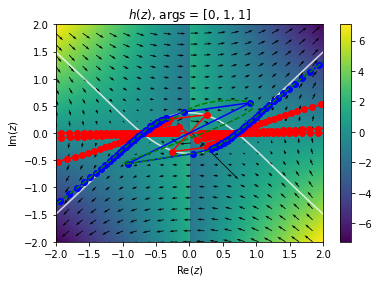

In [59]:
# Plot stuff
morsefun = plind.get_morse()
y, a, b = expargs
critpts = [0.5*(y + np.sqrt(y**2 + (2/b))), 0.5*(y - np.sqrt(y**2 + (2/b)))]
gradh = plind.get_grad()

domain = [-2, 2]
N = 100
U = np.linspace(domain[0], domain[1], N)
V = np.linspace(domain[0], domain[1], N)
U, V = np.meshgrid(U, V, indexing='ij')
Z = U + 1j*V

fig, ax = plt.subplots()
ax.set_title('$h(z)$, $\\args$ = {}'.format(expargs))
ax.set_xlabel("Re($z$)")
ax.set_ylabel("Im($z$)")
ax.set_ylim(domain[0], domain[1])
ax.set_xlim(domain[0], domain[1])
# Plot h
im = ax.pcolormesh(U, V, morsefun(Z, *expargs).real)
fig.colorbar(im, ax=ax)
for p0 in critpts:
        # Plot critical points
        ax.scatter(p0.real, p0.imag, color='w')
        # Plot contours of expfun.imag passing through p0, p1
        ax.contour(U, V, expfun(Z, *expargs).imag, [expfun(p0, *expargs).imag], colors='w', alpha=0.5)
        
trajectory = plind.get_trajectory()
line = plind.contour

for k in np.linspace(0, trajectory.shape[0], trajectory.shape[0]//10, endpoint=False):
    k = int(k)
    ax.plot(trajectory[k].real[1:-1], trajectory[k].imag[1:-1], 'ro-')

# Plot final contour and gradient
dn = 5
ax.quiver(U[::dn, ::dn], V[::dn, ::dn], gradh(Z[::dn, ::dn], *expargs).real, gradh(Z[::dn, ::dn], *expargs).imag, scale=140, color='k')
ax.plot(line.real[1:-1], line.imag[1:-1], 'bo-')

# Plot spline
contour_spline, contour_spline_der, contour_spline_param = plind.get_contour_spline()
splaram = np.linspace(contour_spline_param[0], contour_spline_param[-1], 5000)
xvals = contour_spline(splaram)
ax.plot(xvals.real, xvals.imag, '--', color='g')

plt.show()

In [60]:
# Plot integrand along contour
intfun = plind.get_intfun()
intvals = intfun(xvals, *expargs)

fig, ax = plt.subplots()
ax.plot(splaram, intvals.real)
ax.plot(splaram, intvals.imag)

plind.integrate(Nint=1000)
print(plind.integral)

(2.7395311895728662+2.1376866194994504j)


/Users/DylanJow/plind/plind/projection/core.py:41: RuntimeWarning: divide by zero encountered in true_divide
  u = X / (1-Z+eps)
/Users/DylanJow/plind/plind/projection/core.py:42: RuntimeWarning: divide by zero encountered in true_divide
  v = Y / (1-Z+eps)
/Users/DylanJow/plind/plind/projection/core.py:44: RuntimeWarning: invalid value encountered in multiply
  z = u + 1j*v
/Users/DylanJow/plind/plind/plmodel.py:115: RuntimeWarning: invalid value encountered in greater
  if np.sum((abs(eval) > DIVERGE)) > 0:


In [61]:
# Try stitching together
contour = plind.contour
contour[49] = -eps+0j
contour[50] = eps+0j
plind.contour = contour[1:]

(-6.911334106599037-5.39566900014215j)

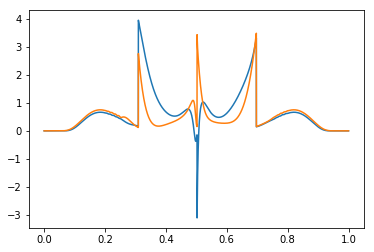

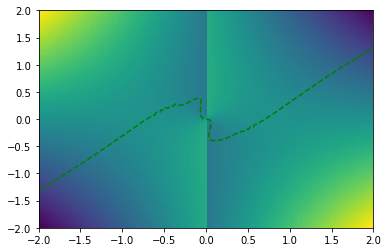

In [62]:
contour_spline, contour_spline_der, contour_spline_param = plind.get_contour_spline()
splaram = np.linspace(contour_spline_param[0], contour_spline_param[-1], 5000)
xvals = contour_spline(splaram)
fig, ax = plt.subplots()
im = ax.pcolormesh(U, V, morsefun(Z, *expargs).real)
ax.set_ylim(domain[0], domain[1])
ax.set_xlim(domain[0], domain[1])
ax.plot(xvals.real, xvals.imag, '--', color='g')
plt.show()

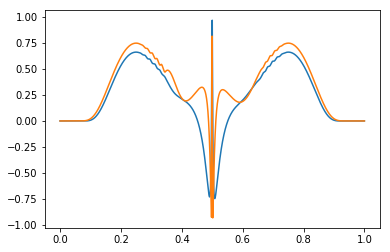

(0.08696837483724079+2.451449274197649j)


In [63]:
intfun = plind.get_intfun()
intvals = intfun(xvals, *expargs)

fig, ax = plt.subplots()
ax.plot(splaram, intvals.real)
ax.plot(splaram, intvals.imag)
plt.show()

plind.integrate(Nint=1000)
print(plind.integral)

In [64]:
# Get mathematica answer
def answer(a, b):
    A = gamma(0.5 - 0.5*1j*a)*(a**2*b**2)**(-0.25*(1-1j*a))
    B = np.cosh(0.25*np.pi*(1j+a)) + 1j*np.cosh(0.25*np.pi*(-1j+a))*np.sign(a)*np.sign(b)
    return A*B

print(answer(1, 1))

(0.08506620828486455+2.452687390140225j)


0.022361012565723343